# Optimización multiobjetivo

cada individuo son dos vectores de n_dims, y cada vector tiene su fitness de rastrigin.

La optimización de pareto es para cada valor menor de la dimensión.

Se buscan los dominantes de cada individuo

El individuo se cruza con sus dominantes por differential evolution.

Se itera.

https://www.sfu.ca/~ssurjano/rastr.html

In [1]:
import numpy as np
import pandas as pd
import random
import math
import csv
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')

from multiprocessing import Pool

import time
import copy
import os

In [2]:
n_dims=20
cant_indiv=100
iteraciones=100000
iter_experimentos=3#0
n_reports=20

min_factible=-5.12 
max_factible=5.12

f_param=1.6
sigma_pso=0.0005
sigma_mut=0.15
mut_param=0.5#0.4
cr_param=0.3#0.6
elitist=False

In [3]:
def rastrigin(X_array, A=10, m=0):
    n=len(X_array)
    y=A*n+(sum([(x_val**2)-(A*math.cos(2*math.pi*x_val))for x_val in X_array]))
    return y

def rastrigin_dim(vec_coords, A=10):
    return np.array([[vc,rastrigin(vc)] for vc in vec_coords])
    #return np.array([[x_val,A+((x_val**2)-(A*math.cos(2*math.pi*x_val)))]for x_val in vec_coords])

def b_doms_a(ind_a,ind_b):
    #Recive dos indivi y compara si todas las dimensiones de B son menores de A, True si B es dominante de A
    return np.all(ind_b[:,1]<ind_a[:,1])

# Generar un vector de n_dims dimensiones entre los valores factibles.
def rand_vec():
    X_array=[random.uniform(min_factible,max_factible) for i in xrange(n_dims)]
    return np.array(X_array)

def limit_vec(vector):
    for dim in xrange(n_dims):
        if vector[dim]<-5.12:
            vector[dim]=-5.12
        if vector[dim]>5.12:
            vector[dim]=5.12
    return vector

def crossover(target_vector,donnor_vector):# cada individuo es: [vector_función_n,[coordenadas,Fitness]]
#Toma las coordenadas del individuo (target), su donante elegido. P(combina)=cr_param y con P(mutación)=mut_param
    trial_vec=[[],[]]
    for functn in xrange(2):
        for crom_dim in xrange(n_dims):
            pr_cruce=random.random()
            pr_mutac=random.random()
            if pr_cruce>cr_param:
                trial_vec[functn].append(target_vector[functn,0][crom_dim])
            else:
                trial_vec[functn].append(donnor_vector[functn,0][crom_dim])

            if pr_mutac<mut_param:
                trial_vec[functn][crom_dim]=trial_vec[functn][crom_dim]+np.random.normal(scale=sigma_mut)
    return rastrigin_dim(trial_vec)

#PSO Nueva posición de la partícula
def next_pos(particle_mov,dominante): # particula que se mueve(Particle_mov) hacia dominante.
    nw_pos=[[],[]]
    for func_dat, vec_fun in enumerate(particle_mov):
        den_norm=math.sqrt(sum((dominante[func_dat,0]-vec_fun[0])**2))
        nw_pos[func_dat]=np.array([vec_fun[0][i]+(((dominante[func_dat,0][i]-vec_fun[0][i])*sigma_pso)/den_norm) for i in xrange(n_dims)])
    return rastrigin_dim(nw_pos)

In [4]:
def matr_domin (ft_crd_pppl):
    # Toma (Población) un nparray de n_indivs, m_dimensiones, 2 funciones 
    # Retorna matriz de dominancia e indicador de frontera de pareto
    # Dominancia: Cada fitness de dimensión es menor al fitness de comparación; si todas cumplen si, ese indiv es dominante
    dominances=np.array([[b_doms_a(ft_ind_a,ft_ind_b) for ft_ind_b in ft_crd_pppl]for ft_ind_a in ft_crd_pppl])# ind_yi es dominado por ind_xi
    frontieer=np.sum(dominances, axis=1)<1
    return dominances,frontieer

In [5]:
###### Differential Evolution
def next_ind(target,popul):
    # devuelve un individuo seleccionado por differential evolution
    selecs=random.sample(popul,3)
    while any([np.array_equal(target, sel)for sel in selecs]):
        selecs=random.sample(popul,3)
    else:
        donnors=[[],[]]
        for fn_dt in xrange(2):
            base=np.array(selecs[0][:,0][fn_dt])
            vec_2=np.array(selecs[1][:,0][fn_dt])
            vec_3=np.array(selecs[2][:,0][fn_dt])
            donnor=base+(f_param*(vec_2-vec_3))#v_1+F(v_2-v_3)
            donnors[fn_dt]=donnor
        #=limit_vec(donnor)# no es necesario limitarlo, el fitness alto lo elimina.
        donnors=rastrigin_dim(donnors)
        trial=crossover(target,donnors)
        if b_doms_a (target,trial):
            return trial
        else:
            return target

def next_popul(population):
    #Devuelve una lista de tamaño n_indiv seleccionados con differential evolution
    return np.array([next_ind(ith_vec,population)for ith_vec in population])


In [6]:
# Multiobjective Optimization para funciones de PSO y algoritmo genético Simple
# def next_ind(target,dominante,frontera):
#     # Recibe un individuo target, el dominante elegido y su indicador de frontera de Pareto
#     # Devuelve un individuo cruzado si no es frontera
#     selec=None
#     if not frontera:
#         #selec= crossover(target,dominante)
#         selec= next_pos(target,dominante)
#     else:
#         selec= target
#     # Elitista????
#     # Si el hijo domina al padre, el hijo pasa a la próxima generación
#     #if elitist:
#     return selec

# def next_popul(population):
#     #Toma un nparray de n_indivs, m_dimensiones, 2_valores (valor espacio de busqueda y valor fitness para la dimensión)
#     #Devuelve una lista de tamaño n_indiv seleccionados con PSO o algoritmo genético Simple.
#     domins, fronts, donnors = matr_domin(population)
#     return np.array([next_ind(population[ith,:,:],population[donnors[ith],:,:],fronts[ith]) for ith in xrange(cant_indiv)])

In [7]:
# # ########################
# n_dims=10#0
# cant_indiv=50#0
# iteraciones=1000#00
# iter_experimentos=3#0
# n_reports=20
# # ########################

In [ ]:
'''
Crear n_corridas de poblaciones
iterar sobre cada población calculando el fitness del mejor y dejándolo avanzar tantas iteraciones como pueda.
'''
MOO_start_time=time.time()

prim_gen=[np.array([rastrigin_dim([rand_vec(),rand_vec()])for i in xrange(cant_indiv)]) for corr in xrange(iter_experimentos)]
reports=[prim_gen]

for corrida in xrange(iteraciones):
    if __name__ == '__main__':
        pool = Pool()
        prim_gen=pool.map(next_popul,prim_gen)
        pool.close() 
        pool.join()
    
#     fit_dat=np.array([get_best_vec_fit(popul) for popul in prim_gen])# El mejor individuo con fitness de cada población para cada corrida
#     best_popul=list(fit_dat[:,1])# Regstra el mejor fitness de cada población (dentro de la corrida)
#     best_popul_bit=list(fit_dat[:,0])#registra el mejor individuo de cada población
#     best_nCorrds_mIters.append(best_popul)
#     best_corrida_bit=get_best_vec_fit(list(fit_dat[:,0]))
#     best_nCorrds_mIters_bit.append(list(best_corrida_bit[0]))
       
    if corrida %(iteraciones/n_reports)==0:
        print(''.join(["iter: ",str(corrida),"/", str(iteraciones)]))
        reports.append(prim_gen)
        np.save("Results_1/MOO",np.array(reports))
#         with open("Results_1/DifEv_best_ind.csv", 'wb') as f:
#             writer = csv.writer(f)
#             [writer.writerow([best_bit])for best_bit in best_nCorrds_mIters_bit]
reports.append(prim_gen)
np.save("Results_1/MOO",np.array(reports))
# with open("Results_1/DifEv_best_ind.csv", 'wb') as f:
#     writer = csv.writer(f)
#     [writer.writerow([best_bit])for best_bit in best_nCorrds_mIters_bit]

MOO_end_time=time.time()
MOO_exec_time=MOO_end_time-MOO_start_time

iter: 0/100000


In [12]:
print "################################___________________ EXEC TIME:",str(MOO_exec_time)
np.savez("Results_1/MOO",reports)


################################___________________ EXEC TIME: -16799.957535


In [17]:
##################################
# Comparar reporte parcial
##################################
corrid=1
report=21

print(np.array(reports).shape )#(22_reportes, 3_corridas, n_individuos, 2_coordenadas de funciones, 2_fitness)

ft_crd_pppl_test=reports[0][corrid]
domins, fronts = matr_domin(ft_crd_pppl_test)
f_1=np.array(reports[report][corrid])
domins_f_1, fronts_f_1= matr_domin(f_1)
f_1.shape

(22, 3, 100, 2, 2)


(100, 2, 2)

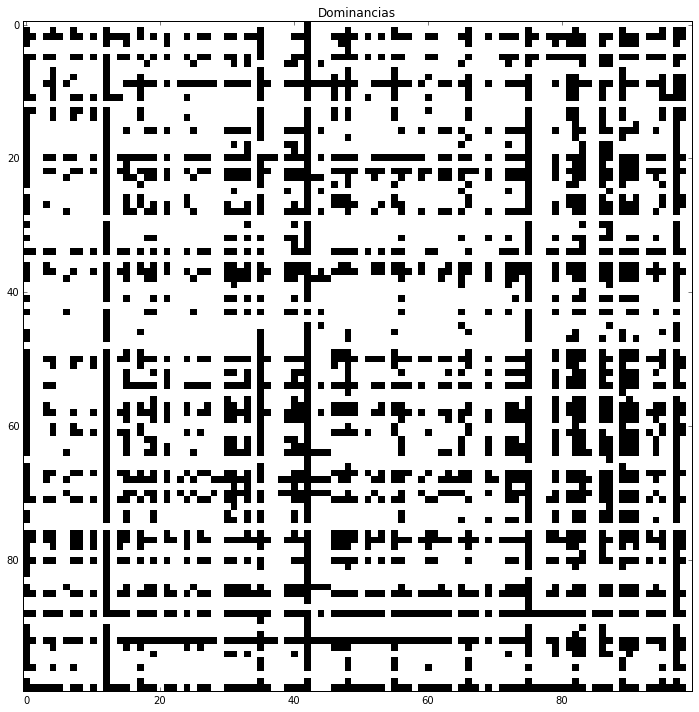

In [18]:
plt.clf()
plt.figure(figsize=(12,12))
plt.title('Dominancias')
plt.imshow(domins,cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

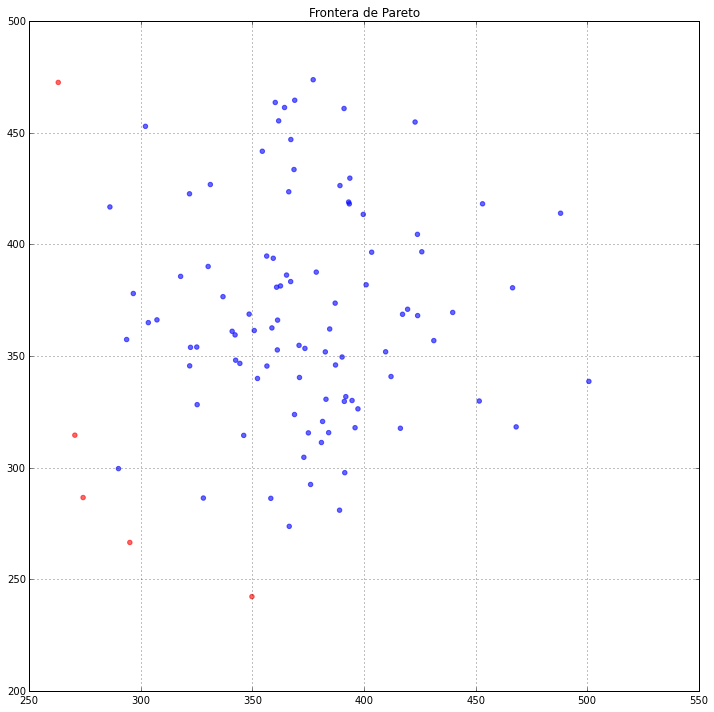

In [19]:
clrs=["r" if dot else "b" for dot in (np.sum(domins, axis=1)<1)]
plt.figure(figsize=(12,12))
plt.title('Frontera de Pareto')
plt.grid()
plt.scatter(ft_crd_pppl_test[:,:,1][:,0],ft_crd_pppl_test[:,:,1][:,1], color=clrs, alpha=0.6)


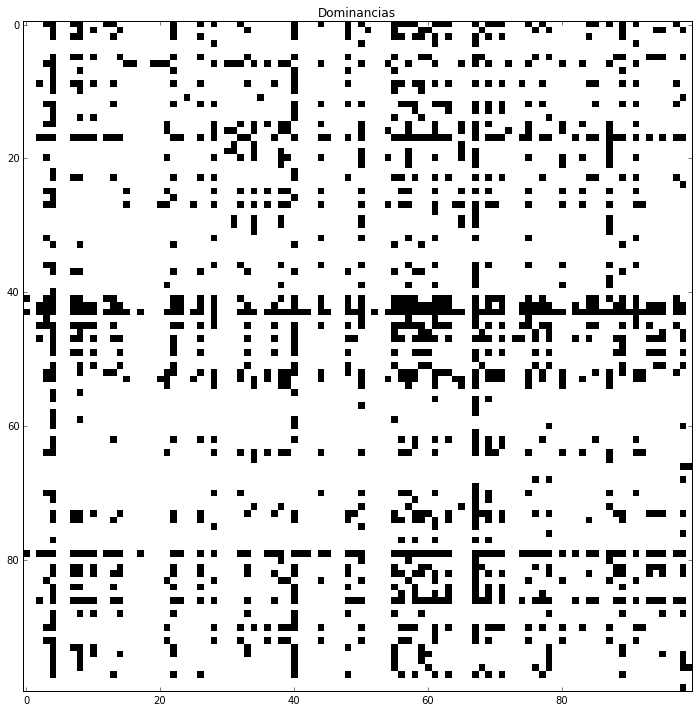

In [20]:
plt.clf()
plt.figure(figsize=(12,12))
plt.title('Dominancias')
plt.imshow(domins_f_1,cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

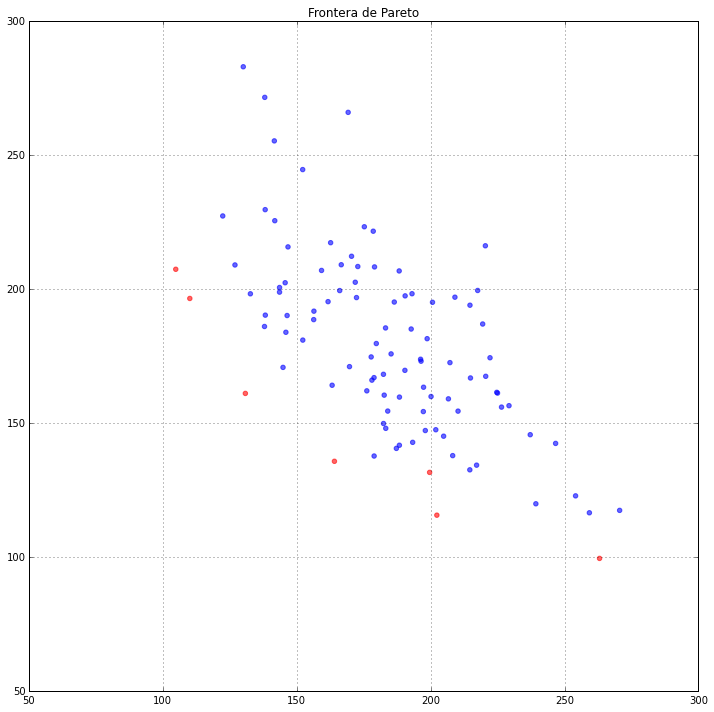

In [21]:
clrs=["r" if dot else "b" for dot in (np.sum(domins_f_1, axis=1)<1)]
plt.figure(figsize=(12,12))
plt.title('Frontera de Pareto')
plt.grid()
plt.scatter(f_1[:,:,1][:,0],f_1[:,:,1][:,1], color=clrs, alpha=0.6)
